<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/31_Pro_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_%D0%9F%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Pro

Макс 10 баллов

Добейтесь точности распознавания жанров музыки не менее 79% стабильно на последних эпохах обучения. 

Используйте разбивку 900 записей на обучающую выборку и 100 на проверочную.

# Загрузка данных и формирование выборки

In [ ]:
import librosa # Для параметризации аудио
import librosa.display # Для отображения аудиосигнала
import matplotlib.pyplot as plt
from google.colab import files # Для загрузки файлов 
import IPython.display as ipd # Для проигрывания аудио
import os
import numpy as np

from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input,  Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Базы/genres.zip'



In [ ]:

genres = os.listdir('genres') # получаем список папок в распакованной папке

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
from librosa.feature.spectral import mfcc
#Функция параметризации аудио
def get_features(y,sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по усолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) # Мел кепстральные коэффициенты (по усолчанию 20)

  rmse = np.mean(librosa.feature.mfcc(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) # Среднее спектрального центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) # Среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # Cредняя частота пересечения нуля звукового временного ряда

  # Добавляем все параметры в дин список
  out = [] # создаем пустой список
  out.append(rmse) # добавляе среднеквадратиную амплитуду
  out.append(spec_cent) # добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля 

  # Дбавляем среднее всех мел кепстральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  # Добавляем среднее всех частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time # подкючаем модуль time для подсчета времени на обработку одного жанра

# Формируем обучающую Выборку
# Создаем пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жанрам
for i in range(len(genres)):
  g = genres[i] # берем текущий жанр
  # Проходим по файлам папки текущего жанра
  for filename in os.listdir(f'./genres/{g}'):
    # получаем имя песни
    songname = f'./genres/{g}/{filename}'
    # загружаем в аудиосигнал
    # используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono = True, duration = 30) # y - массив данных временного ряда аудио, sr - частота дискретизации
    # Превращаем сигнал в параметризованные данные
    out = get_features(y,sr)

    # добавляем строку в X_train
    X_train.append(out)
    # добавляем в Y_train номер жанра в OHE
    Y_train.append(to_categorical(i, len(genres)))

  # Выводим инфо о готовности обработки базы
  print('Жанр ', g, ' готов  -->', round(time.time() - curr_time), 'c', sep='')
  curr_time = time.time()

# Превращаем обучающую выборку в numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)





Жанр disco готов  -->58c
Жанр classical готов  -->56c
Жанр metal готов  -->58c
Жанр hiphop готов  -->56c
Жанр rock готов  -->56c
Жанр blues готов  -->56c
Жанр jazz готов  -->55c
Жанр country готов  -->56c
Жанр reggae готов  -->55c
Жанр pop готов  -->55c


In [ ]:
# Создаем back up обучающей выборки 
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
# Выводим номера классов , чтобы проверить, что все правильно заполнилось
# И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train[0])

[ 1.02677672  0.7508175   0.70572228  0.72386235  0.67232121  0.8667037
 -0.99569476 -0.29209579 -0.77319038  1.30987817 -0.12337336  0.73799999
  0.25804642  0.85302284  0.63695051  0.89025183 -0.16327524  0.91038507
 -0.14559957  0.9061849   0.39899606  1.51141758  0.90768989  0.75943242
  0.79516832  1.46997584  0.55689361 -0.12760101 -0.17761546  0.20419492
 -0.30305802 -0.15132985  0.76186087  0.72290721  1.04741353  0.46299054
  0.71783771]


In [ ]:
# Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
# Создаем scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
# Нормируем X_train
X_train = scaler.fit_transform(X_train)


In [ ]:
# Проверяем , что X_train нормировался
print(X_train[0])


[ 0.68698327  0.17716397  0.35999761  0.18832912 -0.0586215   0.37046707
 -0.27193921  0.02630248 -0.11935419 -0.06429072 -0.91529007  1.575827
 -0.43573743  1.68353867 -0.37179606  0.98417097 -1.24022711  0.35948969
 -0.53631229  2.23728709  0.5759105   1.60786333  1.21423446  1.38632156
  1.11516066 -1.26114836 -1.41195494 -0.41706385 -0.66990228  0.44873842
 -0.95565882 -0.22604159  1.13502997 -0.32833617  0.76823179 -1.20541908
  0.12415849]


In [ ]:
# Разделяем выборку на обучающую и проверочную (90% и 10%)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
# Выводим размеры обучающей и проверочной выборки, для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


# Полносвязная сеть relu + Dropout

Epoch 1/450
15/15 [==============================] - 1s 19ms/step - loss: 2.3226 - accuracy: 0.1067 - val_loss: 2.2769 - val_accuracy: 0.0600
Epoch 2/450
15/15 [==============================] - 0s 6ms/step - loss: 2.2923 - accuracy: 0.1244 - val_loss: 2.2537 - val_accuracy: 0.1200
Epoch 3/450
15/15 [==============================] - 0s 7ms/step - loss: 2.2683 - accuracy: 0.1200 - val_loss: 2.2303 - val_accuracy: 0.2100
Epoch 4/450
15/15 [==============================] - 0s 6ms/step - loss: 2.2403 - accuracy: 0.1789 - val_loss: 2.2066 - val_accuracy: 0.2500
Epoch 5/450
15/15 [==============================] - 0s 6ms/step - loss: 2.2164 - accuracy: 0.2067 - val_loss: 2.1819 - val_accuracy: 0.3100
Epoch 6/450
15/15 [==============================] - 0s 8ms/step - loss: 2.2147 - accuracy: 0.1944 - val_loss: 2.1578 - val_accuracy: 0.3200
Epoch 7/450
15/15 [==============================] - 0s 6ms/step - loss: 2.1896 - accuracy: 0.2267 - val_loss: 2.1314 - val_accuracy: 0.3300
Epoch 8/450


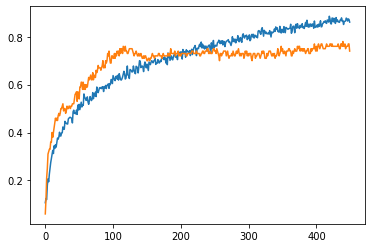

In [ ]:
indexes = range(0,37)

# Cоздаем полносвязную сеть
model_relu_D = Sequential()

model_relu_D.add(Dense(256, activation='relu', input_shape = (len(indexes),)))
model_relu_D.add(Dropout(0.25))
model_relu_D.add(Flatten())

model_relu_D.add(Dense(128, activation='relu'))
model_relu_D.add(Dropout(0.25))

model_relu_D.add(Dense(64, activation='relu'))
model_relu_D.add(Dropout(0.2))

model_relu_D.add(Dense(128, activation='relu'))
model_relu_D.add(Dense(10, activation='softmax'))

#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=450,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/200
15/15 [==============================] - 3s 29ms/step - loss: 0.4122 - accuracy: 0.8556 - val_loss: 0.8638 - val_accuracy: 0.7800
Epoch 2/200
15/15 [==============================] - 0s 9ms/step - loss: 0.3654 - accuracy: 0.8744 - val_loss: 0.8628 - val_accuracy: 0.7600
Epoch 3/200
15/15 [==============================] - 0s 8ms/step - loss: 0.3625 - accuracy: 0.8689 - val_loss: 0.8771 - val_accuracy: 0.7600
Epoch 4/200
15/15 [==============================] - 0s 8ms/step - loss: 0.3181 - accuracy: 0.8956 - val_loss: 0.8795 - val_accuracy: 0.7700
Epoch 5/200
15/15 [==============================] - 0s 9ms/step - loss: 0.3430 - accuracy: 0.8778 - val_loss: 0.8725 - val_accuracy: 0.7600
Epoch 6/200
15/15 [==============================] - 0s 9ms/step - loss: 0.3651 - accuracy: 0.8667 - val_loss: 0.8719 - val_accuracy: 0.7700
Epoch 7/200
15/15 [==============================] - 0s 9ms/step - loss: 0.3801 - accuracy: 0.8622 - val_loss: 0.8697 - val_accuracy: 0.7700
Epoch 8/200


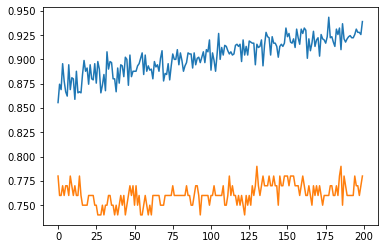

In [ ]:
#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/300
15/15 [==============================] - 1s 18ms/step - loss: 0.2352 - accuracy: 0.9200 - val_loss: 0.9437 - val_accuracy: 0.7800
Epoch 2/300
15/15 [==============================] - 0s 6ms/step - loss: 0.2303 - accuracy: 0.9178 - val_loss: 0.9441 - val_accuracy: 0.7800
Epoch 3/300
15/15 [==============================] - 0s 5ms/step - loss: 0.2277 - accuracy: 0.9289 - val_loss: 0.9438 - val_accuracy: 0.7800
Epoch 4/300
15/15 [==============================] - 0s 6ms/step - loss: 0.2292 - accuracy: 0.9233 - val_loss: 0.9430 - val_accuracy: 0.7800
Epoch 5/300
15/15 [==============================] - 0s 5ms/step - loss: 0.2095 - accuracy: 0.9300 - val_loss: 0.9455 - val_accuracy: 0.7800
Epoch 6/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1958 - accuracy: 0.9233 - val_loss: 0.9466 - val_accuracy: 0.7800
Epoch 7/300
15/15 [==============================] - 0s 6ms/step - loss: 0.2059 - accuracy: 0.9289 - val_loss: 0.9471 - val_accuracy: 0.7800
Epoch 8/300


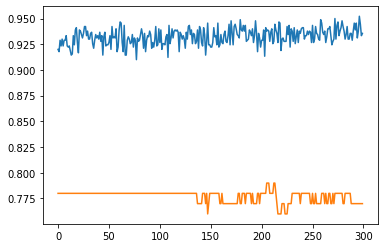

In [ ]:
#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-5),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=300,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/300
15/15 [==============================] - 1s 17ms/step - loss: 0.2039 - accuracy: 0.9278 - val_loss: 1.0034 - val_accuracy: 0.7600
Epoch 2/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1920 - accuracy: 0.9422 - val_loss: 0.9911 - val_accuracy: 0.7700
Epoch 3/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1873 - accuracy: 0.9300 - val_loss: 1.0048 - val_accuracy: 0.7800
Epoch 4/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1685 - accuracy: 0.9389 - val_loss: 1.0075 - val_accuracy: 0.7800
Epoch 5/300
15/15 [==============================] - 0s 6ms/step - loss: 0.2002 - accuracy: 0.9378 - val_loss: 1.0215 - val_accuracy: 0.7800
Epoch 6/300
15/15 [==============================] - 0s 5ms/step - loss: 0.1894 - accuracy: 0.9322 - val_loss: 1.0206 - val_accuracy: 0.7800
Epoch 7/300
15/15 [==============================] - 0s 5ms/step - loss: 0.2069 - accuracy: 0.9278 - val_loss: 1.0066 - val_accuracy: 0.7800
Epoch 8/300


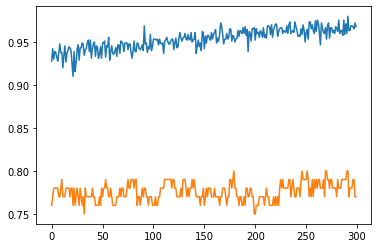

In [ ]:
#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=300,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
model_relu_D.save('relu_d_77.h5')

Epoch 1/100
15/15 [==============================] - 2s 35ms/step - loss: 0.1152 - accuracy: 0.9600 - val_loss: 1.2115 - val_accuracy: 0.7600
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0975 - accuracy: 0.9644 - val_loss: 1.2221 - val_accuracy: 0.7700
Epoch 3/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0935 - accuracy: 0.9722 - val_loss: 1.2177 - val_accuracy: 0.7700
Epoch 4/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1119 - accuracy: 0.9644 - val_loss: 1.2119 - val_accuracy: 0.7800
Epoch 5/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0846 - accuracy: 0.9778 - val_loss: 1.2108 - val_accuracy: 0.7900
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.1233 - accuracy: 0.9544 - val_loss: 1.2244 - val_accuracy: 0.8000
Epoch 7/100
15/15 [==============================] - 0s 12ms/step - loss: 0.1116 - accuracy: 0.9644 - val_loss: 1.2091 - val_accuracy: 0.7900
Epoch 

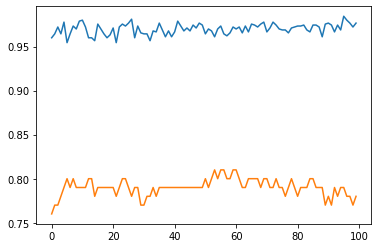

In [ ]:
#Компилируем сеть 
model_relu_D.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучаем
history = model_relu_D.fit(X_train[:,indexes],
                    y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data = (X_test[:, indexes], y_test))

# выводим график обучения
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()